In [128]:
from scipy.io import wavfile
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
import museval

In [129]:
x1, fs1 = sf.read('x1.wav')
x2, fs2 = sf.read('x2.wav')
x3, fs3 = sf.read('x3.wav')
s1, fs_s1 = sf.read('s1.wav')
s2, fs_s2 = sf.read('s2.wav')
s3, fs_s3 = sf.read('s3.wav')

In [130]:
# 標準化
M = len(x1)#信号のサンプル数
x = np.zeros((3, len(x1)))
x[0,:] = (x1 - np.mean(x1))/np.sqrt(np.nanvar(x1))
x[1,:] = (x2 - np.mean(x2))/np.sqrt(np.nanvar(x2))
x[2,:] = (x3 - np.mean(x3))/np.sqrt(np.nanvar(x3))
print(x.shape)

# 観測信号の白色化化
R = np.dot(x, x.T)/M
eig_v, Q = np.linalg.eig(R)
Lambda = np.diag(eig_v)
V = np.dot(np.sqrt(np.linalg.inv(Lambda)), Q.T)
xh = np.dot(V,x)

b_past = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
b = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
print(b.shape)

def ICA(m_component, max_iter):
    for m in range(m_component):
        for i in range(max_iter):
            b_past[:,m] = b[:,m]
            sh = np.dot(b[:,m].T, xh)
            # fourth moment - kurtosis
            b[:,m] = np.mean(xh * np.power(sh,3).reshape(1, -1), axis=1) - 3*b[:,m]

            # Gram-Schmidt process
            if m > 0:
                for j in range(m):
                    b[:,m] -= np.dot(np.dot(b[:,m].T, b[:,j]), b[:,j])
            
            # Normalize
            b[:,m] /= np.linalg.norm(b[:,m])
            
            if np.abs(np.abs(np.dot(b[:,m].T, b_past[:,m])) - 1) < 10**-6:
                break
        # print("iteration = ",i)
    return np.dot(b.T, xh)  

sh = ICA(3,100)
s = np.vstack((s1,s2,s3))
print(sh.shape,xh.shape)

(3, 441000)
(3, 3)
(3, 441000) (3, 441000)


In [131]:
signal_power = np.var(s, axis=1)   # Power of original signal 
noise_power = np.var((s - sh),axis=1)
print(noise_power)
snr = 10*np.log10(signal_power/noise_power)
print("SNR : ",snr)

[0.77018737 0.81391955 0.78529913]
SNR :  [-17.10622238 -19.19855874 -17.74281491]


In [132]:
MSE = []
for i in range(3):
    MSE = np.append(MSE,np.sum(np.power((s[i,:] - sh[i,:]),2))/(sh.shape[1]))
print('MSE :',MSE)

MSE : [0.77018737 0.81391955 0.78529913]


In [133]:
SDR,ISR,SIR,SAR = museval.evaluate(s,sh)
print('SDR :',np.mean(SDR,axis=1))
print('ISR :',np.mean(ISR,axis=1))
print('SIR :',np.mean(SIR,axis=1))
print('SAR :',np.mean(SAR,axis=1))

SDR : [-17.10632178 -19.20646448 -17.73951848]
ISR : [-17.10127828 -19.07733429 -17.64756726]
SIR : [30.80677985 16.67016714 17.91206432]
SAR : [63.98812145 69.74221787 63.09690591]


(441000, 6)


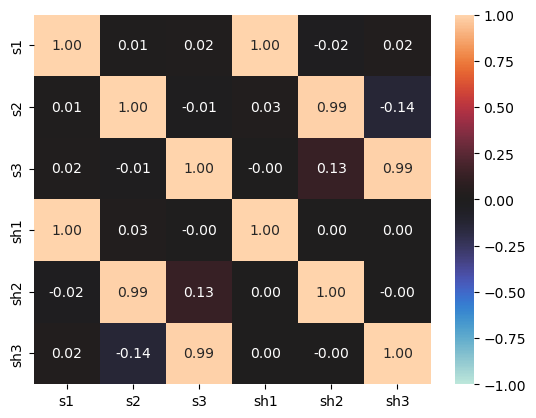

In [134]:
s_sh = np.concatenate((s,sh),axis= 0).T
print(s_sh.shape)
df = pd.DataFrame(s_sh, columns = ['s1','s2','s3','sh1','sh2','sh3'])
corr_mat = df.corr(method='pearson')
import seaborn as sns
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.2f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()


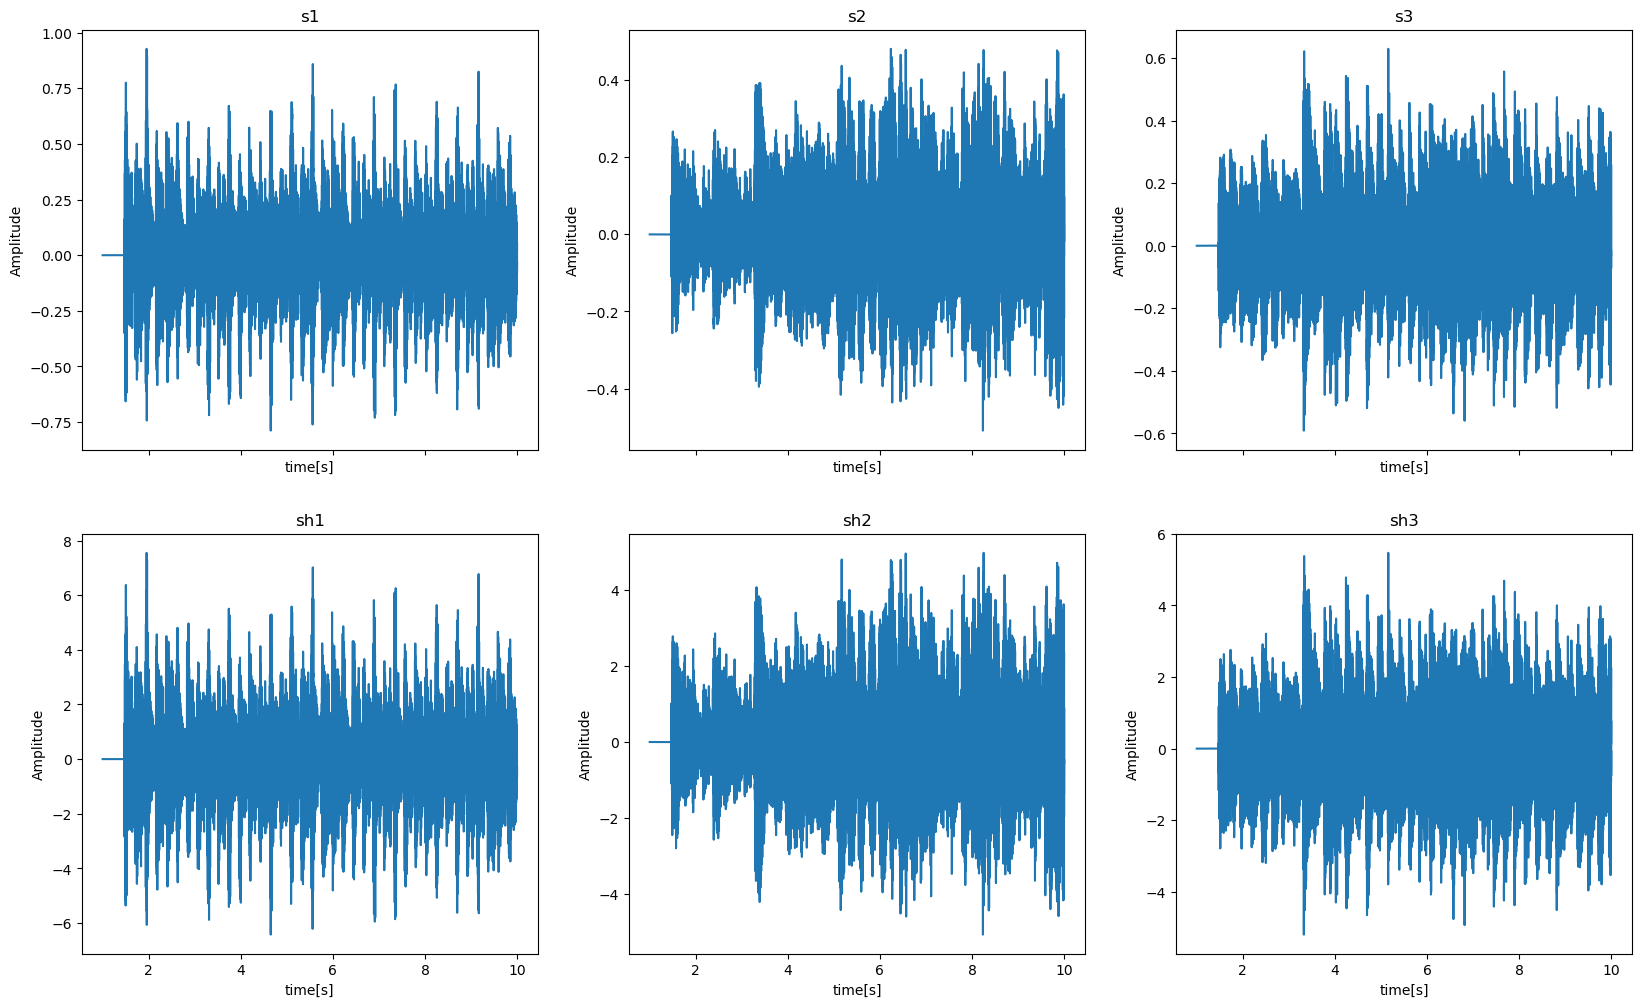

In [135]:
t = np.linspace(1,10,fs_s1*10)
s_title = ["s1","s2","s3"]
sh_title = ["sh1","sh2","sh3"]
fig, axs = plt.subplots(2, 3,figsize=(20, 12),sharex= True)
for i in range(2):
    if (i == 0):
        y = s
        title = s_title
    else:
        y = sh
        title = sh_title
    for j in range(3):
        axs[i, j].plot(t, y[j,:])
        axs[i, j].set_title(title[j])
for ax in axs.flat:
    ax.set(xlabel='time[s]', ylabel='Amplitude')